#Credit Scoring: Predict the probability of going default 
    Algorithm: Logistic Regression (10 features with 1 target)

    Data: https://www.kaggle.com/c/GiveMeSomeCredit
    
    By: Hee Kyung, Yoon

In [1]:
%matplotlib inline 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.optimize import fmin_cg
from sklearn.metrics import precision_recall_fscore_support

#Table of Contents
# I. BUILD MODEL
1. LOAD DATA

2. PROCESS DATA (-> X, y)

3. TRAIN (-> theta)

4. PREDICT (-> h(x))

5. GET ACCURACY & F-SCORE



# II. MODIFY MODEL
1. Analysis (Learning Curve) -> high bias or high variance?

2. Modify Lambda

3. Modify Threshold

4. Add/Drop features

5. Modified Model

-------------------------------------------------------------


# I. BUILD MODEL
## 1. LOAD DATA
    load data
    split data into training, cross validation and test data sets

## 2. PROCESS DATA (-> X, y)
    feature scaling
    add bias terms

## 3. TRAIN (-> theta)
    theta = fmincg(CostFunction, X, y, lambda, initial_theta)

    (J, grad) = CostFunction(X, y, lambda)

## 4. PREDICT (-> h(x))

    h = predict(X)

## 5. GET ACCURACY & F-SCORE

In [2]:
# 1. Load Data


def load(filename):
    '''
    filenname: string ('test.csv')
    
    returns: DataFrame
    '''
    data = pd.DataFrame.from_csv(filename, encoding = 'utf-8')
    print '\nData Columns:'
    for i in range(len(data.columns)):
        print '\t',i,'\t', data.columns[i]

    check(data)
    
    return data

def check(X):
    '''
    X: DataFrame or Series
    
        prints shape and head
    
    returns: None
    '''
    print '\nShape is:\n', X.shape
    print X.head()

data = load('cs-training.csv')


Data Columns:
	0 	SeriousDlqin2yrs
	1 	RevolvingUtilizationOfUnsecuredLines
	2 	age
	3 	NumberOfTime30-59DaysPastDueNotWorse
	4 	DebtRatio
	5 	MonthlyIncome
	6 	NumberOfOpenCreditLinesAndLoans
	7 	NumberOfTimes90DaysLate
	8 	NumberRealEstateLoansOrLines
	9 	NumberOfTime60-89DaysPastDueNotWorse
	10 	NumberOfDependents

Shape is:
(150000, 11)
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982           9120   
2                                     0   0.121876           2600   
3                                     1   0.085113  

In [3]:
#Split data into training data, cross validation data, and test data


'''
# Shuffle index
index = np.array(data.index)
random.shuffle(index)

print index.shape
print index

# training set (60%)
trainingSize = data.shape[0] * 0.60
training = data.ix[index[:trainingSize]]

training.to_csv('training.csv', encoding='utf-8')

print '\n', training.shape
print training.head()

# crossValidation set (20%)
crossValSize = data.shape[0] * 0.20
crossValidation = data.ix[index[trainingSize:trainingSize + crossValSize]]

crossValidation.to_csv('crossValidation.csv', encoding='utf-8')

print '\n', crossValidation.shape

# test set (20%)
test = data.ix[index[trainingSize + crossValSize:]]

test.to_csv('test.csv', encoding = 'utf-8')

print '\n', crossValidation.shape
'''

"\n# Shuffle index\nindex = np.array(data.index)\nrandom.shuffle(index)\n\nprint index.shape\nprint index\n\n# training set (60%)\ntrainingSize = data.shape[0] * 0.60\ntraining = data.ix[index[:trainingSize]]\n\ntraining.to_csv('training.csv', encoding='utf-8')\n\nprint '\n', training.shape\nprint training.head()\n\n# crossValidation set (20%)\ncrossValSize = data.shape[0] * 0.20\ncrossValidation = data.ix[index[trainingSize:trainingSize + crossValSize]]\n\ncrossValidation.to_csv('crossValidation.csv', encoding='utf-8')\n\nprint '\n', crossValidation.shape\n\n# test set (20%)\ntest = data.ix[index[trainingSize + crossValSize:]]\n\ntest.to_csv('test.csv', encoding = 'utf-8')\n\nprint '\n', crossValidation.shape\n"

In [4]:
# load split data

training = load('training.csv')
cv = load('crossValidation.csv')
test = load('test.csv')


Data Columns:
	0 	SeriousDlqin2yrs
	1 	RevolvingUtilizationOfUnsecuredLines
	2 	age
	3 	NumberOfTime30-59DaysPastDueNotWorse
	4 	DebtRatio
	5 	MonthlyIncome
	6 	NumberOfOpenCreditLinesAndLoans
	7 	NumberOfTimes90DaysLate
	8 	NumberRealEstateLoansOrLines
	9 	NumberOfTime60-89DaysPastDueNotWorse
	10 	NumberOfDependents

Shape is:
(90000, 11)
        SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
42082                  1                              1.173509   33   
47463                  0                              0.040118   67   
6412                   0                              0.228882   68   
142967                 0                              0.558521   50   
51191                  0                              0.000000   65   

        NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
42082                                      3   0.430443           5570   
47463                                      0   0.007237          10500   
6412    

# I.2. PROCESS DATA (-> X, y)
##featureScale
##addBias

In [5]:
# 0. PROCESS DATA (-> X, y)
def splitData(Xandy):
    '''
    Xandy:
    
    returns: X, y
    '''
    X = Xandy.iloc[:, 1:]
    #check(Xtrain)

    y = Xandy['SeriousDlqin2yrs']
    #check(ytrain)
    
    # fill nan with 0
    X = X.fillna(0)
    y = y.fillna(0)
    return X, y

Xtrain, ytrain = splitData(training)
(m, n) = Xtrain.shape # m: # of examples /n: # of attributes

# feature scaling
def featureScale(X):
    '''
    X: DataFrame
    
    returns: DataFrame (feature scaled)
    '''
    for col in range(X.shape[1]):
        #print 'col index:', col
        copied = X.iloc[:, col]
        #print 'head\n', copied.head()
        #print 'mean: ', copied.mean()
        #print 'std: ', copied.std()
        X.iloc[:, col] = (copied - copied.mean())/copied.std()
    return X

Xtrain = featureScale(Xtrain)
check(Xtrain)
     
# Add Bias terms to Xtrain
def addBias(X):
    '''
    X: DataFrame (m * n)
    
        Adds bias terms to the first column
    
    returns: DataFrame (m * (n + 1))
    '''
    X.insert(0, 'Bias', 1)
    return X

Xtrain = addBias(Xtrain)
check(Xtrain)




Shape is:
(90000, 10)
        RevolvingUtilizationOfUnsecuredLines       age  \
42082                              -0.021570 -1.303803   
47463                              -0.027005  0.996573   
6412                               -0.026100  1.064231   
142967                             -0.024519 -0.153615   
51191                              -0.027197  0.861257   

        NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
42082                               0.599827  -0.240037       0.018670   
47463                              -0.100036  -0.240334       0.435878   
6412                               -0.100036  -0.240243      -0.125025   
142967                             -0.100036  -0.240191       0.630518   
51191                              -0.100036  -0.240334      -0.135349   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
42082                          0.889610                 1.108264   
47463                          1.669514        

In [6]:
Xcv, ycv = splitData(cv)
Xcv = featureScale(Xcv)
Xcv = addBias(Xcv)

Xtest, ytest = splitData(test)
Xtest = featureScale(Xtest)
Xtest = addBias(Xtest)

# I.3. TRAIN (-> theta)
## theta = fmin_cg(CostFunction, X, y, lambda, initial_theta)
## J = costFunction(X, y, lambda)
## grad = gradFunction

In [7]:


# logisticRegression

L = 0.1

def logisticRegression(costfunction, gradFunction, X, y, L):
    '''
    constFunction: function
    X: matrix
    y: vector
    L (lambda): float
    
    returns: vector (theta)
    '''
    initial_theta = np.zeros(n+1)
    args = (X, y, L)
    theta = fmin_cg(f = costFunction, x0 = initial_theta, \
                    fprime = gradFunction, args = args)
    return theta

# costFunction
def costFunction(theta, *args):
    '''
    theta: vector
    X: matrix
    y: vector
    L (lambda): float
    
    returns: float (J)
    '''
    #J = sum(np.multiply(np.log(sigmoid(X.dot(theta))), -y) - \
    #       np.multiply((1 - y),log(1 - sigmoid(X.dot(theta)))))/m 
    theta = theta.reshape((n+1, 1))
    
    X, y, L = args
    y = pd.DataFrame(y)
    y = y.rename(columns = {'SeriousDlqin2yrs':0})
    
    J = np.log(sigmoid(X.dot(theta))).T.dot(-y)
    #print '1',J
    J = J - pd.DataFrame(1 - y).T.dot(np.log(1 - sigmoid(X.dot(theta))))
    #print '2', J
    J = np.sum(J)/m
    #print '3', J
    J = J + (L/(2.0*m)) * np.sum(theta[1:]**2)
    #print '4',J
    
    return np.array(J)

# gradFunction
def gradFunction(theta, *args):
    # grad = transpose(sigmoid(X * y)) * y + lambda * sum(theta[1:])/m
    theta = theta.reshape((n+1, 1))
    
    X, y, L = args
    y = pd.DataFrame(y)
    y = y.rename(columns = {'SeriousDlqin2yrs':0})
    
    grad = X.T.dot(sigmoid(X.dot(theta)) - pd.DataFrame(y))/m
    #print grad.shape
    
    # Regularize
    theta = (L/m)*theta
    theta[0] = 0
    #print theta.shape
    #print theta
    
    grad = np.array(grad + theta)
    grad = grad.reshape(n+1)
    
    return grad

# sigmoid
def sigmoid(z):
    '''
    x: float
    
    returns: float
    '''
    return 1.0/(1.0 + np.exp(-z))






In [24]:
#theta = logisticRegresssion()
theta = np.zeros((n+1, 1))
args = (Xtrain, ytrain, L)
J = costFunction(theta, *args)
print J

[ 0.69314718]


In [25]:
# grad
args = (Xtrain, ytrain, L)
grad = gradFunction(theta, *args)
print grad

[  4.33655556e-01   6.25321947e-05   2.90906540e-02  -3.09406426e-02
   2.10450005e-03   3.37108542e-03   6.87684072e-03  -2.89193348e-02
   1.38170311e-03  -2.54732107e-02  -1.19724349e-02]


In [26]:
# Logistic Regression
#initial_theta = np.zeros((n+1, 1))
theta = logisticRegression(costFunction, gradFunction, Xtrain, ytrain, L)
print theta

Optimization terminated successfully.
         Current function value: 0.224438
         Iterations: 69
         Function evaluations: 183
         Gradient evaluations: 183
[ -2.86431977e+00  -6.70087350e-04  -4.45050396e-01   2.12823601e+00
  -7.15476707e-02  -3.17649717e-01  -2.89580756e-02   1.91868054e+00
   8.10686511e-02  -3.89149063e+00   1.11138614e-01]


# I.4. PREDICT (-> h(x))

    h = predict(X)
    
# I.5. GET ACCURACY & F-SCORE


In [8]:
def predict(theta, X, y, threshold = 0.5):
    '''
    theta
    X
    y
    L
    
        prints measures (accuracy, precision, recall, F-score)
    
    returns: prediction(vector) 
            
    '''
    # get prediction
    prediction = getPrediction(theta, X, threshold)
    
    # get measures
    measures = getMeasures(y, prediction)
    accuracy, precision, recall, fscore = measures
    
    print 'accuracy', accuracy
    print 'precision', precision
    print 'recall', recall
    print 'fscore', fscore
    
    return prediction

def getPrediction(theta, X, threshold = 0.5):
    '''
    
    returns: vector of labels (0, 1)
    '''
    
    probability = sigmoid(X.dot(theta))
    prediction = probability > threshold
    
    return prediction * 1

def getMeasures(y, prediction):
    '''
    
    returns: measures
    '''
    accuracy = (prediction == y).mean()
    
    precision, recall, f_score, support = \
        precision_recall_fscore_support(y, prediction, average = 'binary')
    
    measures = (accuracy, precision, recall, f_score)
    return measures

In [12]:
prediction = predict(theta, Xtest, ytest)
print '\n', prediction

accuracy 0.933633333333
precision 0.547770700637
recall 0.0428713858425
fscore 0.0795191863153

78751     0
54161     0
138873    0
133206    0
76455     0
143419    0
60153     0
16822     0
108037    0
21545     0
108101    0
6890      0
143263    0
123114    0
13659     0
46224     0
96113     0
56733     0
28957     0
133745    0
13232     0
58974     0
106137    0
123718    0
89181     0
39129     0
95773     0
56013     0
28031     0
112550    0
         ..
56040     0
23826     0
112526    0
32885     0
30597     0
104342    0
86670     0
115290    0
12388     0
61321     0
24501     0
125708    0
54324     0
49817     0
143803    0
130927    0
139167    0
5209      0
5354      0
11221     0
142360    0
59997     0
66239     0
141116    0
27769     0
103211    0
26902     0
26924     0
18093     0
78303     0
dtype: int64


# II. MODIFY MODEL
## 1. Analysis (Learning Curve) -> high bias or high variance?
    # of examples - cost relationship
## 2. Modify Lambda
    Lambda - f_score relationship
## 3. Modify Threshold
    threshold - f_score relationship
## 4. Add/Drop features

## 5. Modified Model

# II.1. Analysis (Learning Curve) -> high bias or high variance?
    # of examples - cost relationship

In [15]:
def learningCurve(listOfNum, Xtrain, ytrain, Xcv, ycv, L):
    '''
        prints learning curve
    returns: None
    '''
    costTrain = []
    costCv = []
    
    argsCv = (Xcv, ycv, L)  
    
    for i in listOfNum:
        # slice training examples       
        Xt_part = Xtrain.iloc[0:i,:]
        yt_part = ytrain.iloc[0:i]
        
        # make args pack
        argsTrain = (Xt_part, yt_part, L)
          
        
        # train
        theta = logisticRegression(costFunction, gradFunction, \
                                   Xt_part, yt_part, L)
        
        # get cost based on trained theta
        costTrain.append(costFunction(theta, *argsTrain))
        costCv.append(costFunction(theta, *argsCv))
        print theta, '\n', costTrain, '\n', costCv

    # plot learning curve
    plt.plot(listOfNum, costTrain, label = 'Jtrain')
    plt.plot(listOfNum, costCv, label = 'Jcv')
    
    plt.legend(loc='best')
    plt.xticks(rotation=70) 
    plt.xlabel("# of examples")
    plt.ylabel("J")
    plt.title("Learning Curve")
    
    
    return

Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 66
         Function evaluations: 985
         Gradient evaluations: 985
[-3.62400304  0.09006005 -0.05407074  0.58564913  0.30842175  0.08476902
 -0.03868736  0.83343996  0.17248527  0.59644998  0.85138838] 
[array([  7.23879564e-05])] 
[array([ nan])]
Optimization terminated successfully.
         Current function value: 0.012060
         Iterations: 350
         Function evaluations: 3921
         Gradient evaluations: 3921
[-2.95481362 -0.23018433 -0.41598678  2.28119131 -0.18716682 -0.65530014
 -0.07243876  1.25772778  0.08696076 -3.42948066  0.12577474] 
[array([  7.23879564e-05]), array([ 0.01205988])] 
[array([ nan]), array([ 0.07608986])]
Optimization terminated successfully.
         Current function value: 0.025092
         Iterations: 140
         Function evaluations: 1197
         Gradient evaluations: 1197
[-2.85698468 -0.1967097  -0.38722378  2.05459445 -0.099      -0.35

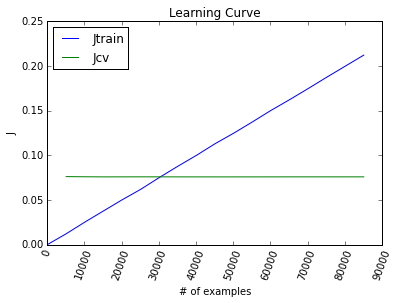

In [29]:
learningCurve(range(100, m, 5000), Xtrain, ytrain, Xcv, ycv, L)

# II.2. Modify Lambda
    Lambda - f_score relationship

In [17]:
def bestLambda(listOfNum, Xtrain, ytrain, Xcv, ycv):
    '''
        prints lambda - f_score relationship
    returns: best lambda
    '''
    fscoreCv = []
    costCv = []
    
    for i in listOfNum:
        argsCv = (Xcv, ycv, i)    
        
        # train
        theta = logisticRegression(costFunction, gradFunction, \
                                   Xtrain, ytrain, i)
        
        # get fscore based on trained theta
        # get prediction
        prediction = getPrediction(theta, Xcv)

        # get measures
        measures = getMeasures(ycv, prediction)
        accuracy, precision, recall, fscore = measures
        
        fscoreCv.append(fscore)
        costCv.append(costFunction(theta, *argsCv))

    # plot learning curve
    plt.plot(listOfNum, fscoreCv, label = 'F-score')
    plt.plot(listOfNum, costCv, label = 'Jcv')
    
    plt.legend(loc='best')
    plt.xticks(rotation=70) 
    plt.xlabel("Lambda")
    plt.ylabel("F-score")
    plt.title("Lambda - F-score relationship")
    
    maxFscore = max(fscoreCv)
    maxIndexF = fscoreCv.index(maxFscore)
    
    minCostCv = min(costCv)
    minIndexCost = costCv.index(minCostCv)
    
    return listOfNum[maxIndexF], listOfNum[minIndexCost]


Optimization terminated successfully.
         Current function value: 0.224425
         Iterations: 80
         Function evaluations: 213
         Gradient evaluations: 213
Optimization terminated successfully.
         Current function value: 0.224438
         Iterations: 70
         Function evaluations: 187
         Gradient evaluations: 187
Optimization terminated successfully.
         Current function value: 0.224452
         Iterations: 92
         Function evaluations: 235
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: 0.224465
         Iterations: 86
         Function evaluations: 245
         Gradient evaluations: 245
Optimization terminated successfully.
         Current function value: 0.224478
         Iterations: 89
         Function evaluations: 236
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: 0.224491
         Iterations: 92
         Function evaluati

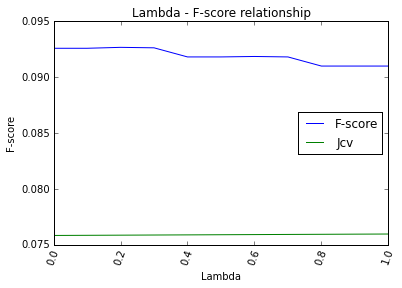

In [18]:
bestL_F, bestL_Cost = bestLambda(np.linspace(0, 1, 11), Xtrain, ytrain, Xcv, ycv)
print '\nLambda that maximizes F-score >>', bestL_F
print '\nLambda that minimizes Cost >>', bestL_Cost

# II.3. Modify Threshold
    Threshold - F-score relationship

In [19]:
def bestThreshold(listOfNum, Xtrain, ytrain, Xcv, ycv, L):
    '''
        prints threshold - f_score relationship
    returns: best threshold
    '''
    fscoreCv = []
    accuracyCv = []
    costCv = []
    
    
    # train
    theta = logisticRegression(costFunction, gradFunction, \
                                   Xtrain, ytrain, L)
    argsCv = (Xcv, ycv, L)
    
    # for different number of thresholds
    for i in listOfNum:
        
        # get fscore based on trained theta
        # get prediction
        prediction = getPrediction(theta, Xcv, threshold = i)

        # get measures
        measures = getMeasures(ycv, prediction)
        accuracy, precision, recall, fscore = measures
        
        fscoreCv.append(fscore)
        accuracyCv.append(accuracy)
        costCv.append(costFunction(theta, *argsCv))

    # plot learning curve
    plt.figure()
    plt.plot(listOfNum, fscoreCv, label = 'F-score')
    plt.plot(listOfNum, accuracyCv, label = 'Accuracy')
    plt.plot(listOfNum, costCv, label = 'Jcv')
    
    plt.legend(loc='best')
    plt.xticks(rotation=70) 
    plt.xlabel("Threshold")
    plt.ylabel("F-score")
    plt.title("Threshold - F-score relationship")
    
    maxFscore = max(fscoreCv)
    maxIndex = fscoreCv.index(maxFscore)
    
    return listOfNum[maxIndex]


Optimization terminated successfully.
         Current function value: 0.224452
         Iterations: 105
         Function evaluations: 298
         Gradient evaluations: 298
Threshold that maximizes F-score >> 0.125
Optimization terminated successfully.
         Current function value: 0.224425
         Iterations: 88
         Function evaluations: 228
         Gradient evaluations: 228
Threshold that maximizes F-score >> 0.125


/Users/hee/.pyenv/versions/2.7.9/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


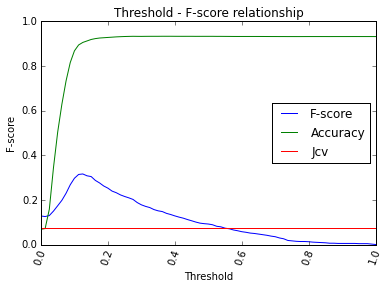

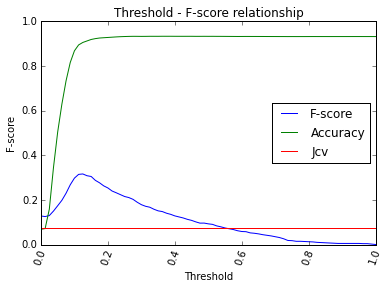

In [20]:
bestT = bestThreshold(np.linspace(0, 1, 81), Xtrain, ytrain, Xcv, ycv, bestL_F)
print 'Threshold that maximizes F-score >>', bestT

bestT = bestThreshold(np.linspace(0, 1, 81), Xtrain, ytrain, Xcv, ycv, bestL_Cost)
print 'Threshold that maximizes F-score >>', bestT

#II.4 Add/Drop Features
    *This time sklearn.linear_model.LogisticRegression module used
    
    add polynomial features
    train
    get f score
    modify C, threshold

In [9]:
from sklearn.preprocessing import PolynomialFeatures

In [10]:
# 1. add polynomial features

poly = PolynomialFeatures(2)

def polyFeature(poly, X):
    '''
    poly: sklearn.preprocessing.PolynomialFeatures
    X: X with bias terms
    
    returns: X with polynomial features
    '''
    X = X.iloc[:, 1:]
    Xpoly = poly.fit_transform(X)
    return Xpoly
    

XtrainPoly = polyFeature(poly, Xtrain)
XcvPoly = polyFeature(poly, Xcv)
XtestPoly = polyFeature(poly, Xtest)

print XtrainPoly.shape, XcvPoly.shape, XtestPoly.shape
print XtrainPoly

(90000, 66) (30000, 66) (30000, 66)
[[ 1.         -0.02156958 -1.30380281 ...,  0.16994545  0.46856373
   1.2918967 ]
 [ 1.         -0.02700473  0.99657329 ...,  0.00339791  0.03881169
   0.44331624]
 [ 1.         -0.02609952  1.06423142 ...,  0.00339791  0.03881169
   0.44331624]
 ..., 
 [ 1.         -0.02327495  1.3348639  ...,  0.00339791  0.03881169
   0.44331624]
 [ 1.         -0.02264996  0.31999209 ...,  0.00339791 -0.01372173
   0.0554123 ]
 [ 1.         -0.02665545  0.38765021 ...,  0.00339791  0.03881169
   0.44331624]]


In [11]:
# 2. train

from sklearn.linear_model import LogisticRegression

clfPoly = LogisticRegression()
clfPoly.fit(XtrainPoly, ytrain)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [23]:
# 3. get f score
def getPredictionModule(clf, X, threshold = 0.5, i = 1):
    '''
    clf: LogisticRegression()
    X
    threshold
    i: 0 or 1(1 if 0 occurs earlier and 0 if 1 occurs earlier)
    
    return: predicted labels for X
    '''
    probaPoly = clf.predict_proba(X)[:,i]
    return probaPoly > threshold

predictionPoly = getPredictionModule(clfPoly, XtestPoly)

ValueError: X has 66 features per sample; expecting 286

In [13]:
print getMeasures(ytest, predictionPoly)

(0.93589999999999995, 0.58153241650294696, 0.14755732801595214, 0.23538767395626242)


In [17]:
# optimum polynomial term
accuracyList = []
fscoreList = []

for i in range(1, 4):
    print '\n', i
    # 1 add polynomial terms
    poly = PolynomialFeatures(i)
    
    XtrainPoly = polyFeature(poly, Xtrain)
    XcvPoly = polyFeature(poly, Xcv)
    
    # 2 train
    clfPoly = LogisticRegression()
    clfPoly.fit(XtrainPoly, ytrain)
    
    # 3 get measures
    accuracy, precision, recall, fscore = getMeasures(ycv, getPredictionModule(clfPoly, XcvPoly, threshold = 0.125))
    accuracyList.append(accuracy)
    fscoreList.append(fscore)
    


1

2

3


In [18]:
fscoreList

[0.31594202898550722, 0.36109750122488976, 0.12736551811582719]

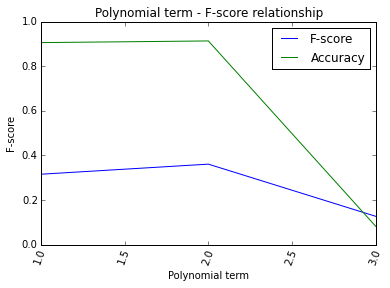

In [20]:
plt.figure()
plt.plot(range(1,4), fscoreList, label = 'F-score')
plt.plot(range(1,4), accuracyList, label = 'Accuracy')

plt.legend(loc='best')
plt.xticks(rotation=70) 
plt.xlabel("Polynomial term")
plt.ylabel("F-score")
plt.title("Polynomial term - F-score relationship")

Polynomial term that maximizes f-score >> 2

In [27]:
poly = PolynomialFeatures(2)

XtrainPoly = polyFeature(poly, Xtrain)
XcvPoly = polyFeature(poly, Xcv)

In [28]:
# 1. C
accuracyList = []
fscoreList = []
for i in np.linspace(1, 10, 10):
   
    # 1 train
    clfPoly = LogisticRegression(C = i)
    clfPoly.fit(XtrainPoly, ytrain)
    
    # 2 get measures
    accuracy, precision, recall, fscore = getMeasures(ycv, \
                                                      getPredictionModule(clfPoly, XcvPoly, threshold = 0.125))
    accuracyList.append(accuracy)
    fscoreList.append(fscore)

    print '\nWhen C = %d, accuracy is %f and f-score is %f.' % (i, accuracy, fscore)


When C = 1, accuracy is 0.912533 and f-score is 0.403094.

When C = 2, accuracy is 0.910533 and f-score is 0.411404.

When C = 3, accuracy is 0.915500 and f-score is 0.383662.

When C = 4, accuracy is 0.912400 and f-score is 0.398902.

When C = 5, accuracy is 0.912533 and f-score is 0.399817.

When C = 6, accuracy is 0.912333 and f-score is 0.399543.

When C = 7, accuracy is 0.913033 and f-score is 0.361634.

When C = 8, accuracy is 0.912500 and f-score is 0.398625.

When C = 9, accuracy is 0.912100 and f-score is 0.398083.

When C = 10, accuracy is 0.911200 and f-score is 0.408263.


C that maximizes F-score >> 2.0


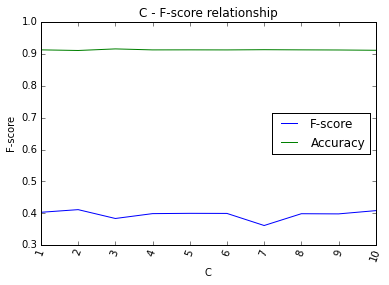

In [29]:
plt.figure()
plt.plot(np.linspace(1,10,10), fscoreList, label = 'F-score')
plt.plot(np.linspace(1,10,10), accuracyList, label = 'Accuracy')

plt.legend(loc='best')
plt.xticks(rotation=70) 
plt.xlabel("C")
plt.ylabel("F-score")
plt.title("C - F-score relationship")

maxFscore = max(fscoreList)
maxIndex = fscoreList.index(maxFscore)

print "C that maximizes F-score >>", np.linspace(1,10,10)[maxIndex]



In [31]:
# 2. Threshold
fscoreList = []
accuracyList = []

for i in np.linspace(0, 1, 81):
   
    # 1 train
    clfPoly = LogisticRegression(C = 2)
    clfPoly.fit(XtrainPoly, ytrain)
    
    # 2 get measures
    accuracy, precision, recall, fscore = getMeasures(ycv, \
                                                      getPredictionModule(clfPoly, XcvPoly, threshold = i))

    fscoreList.append(fscore)
    accuracyList.append(accuracy)
    
    print "When Threshold is %f, accuracy is %f and fscore is %f." % (i, accuracy, fscore)

# plot learning curve
plt.plot(np.linspace(0, 1, 81), fscoreList, label = 'F-score')
plt.plot(np.linspace(0, 1, 81), accuracyList, label = 'Accuracy')

plt.legend(loc='best')
plt.xticks(rotation=70) 
plt.xlabel("Threshold")
plt.ylabel("F-score")
plt.title("Threshold - F-score relationship")



When Threshold is 0.000000, accuracy is 0.068300 and fscore is 0.127867.
When Threshold is 0.012500, accuracy is 0.081500 and fscore is 0.127482.
When Threshold is 0.025000, accuracy is 0.277167 and fscore is 0.152764.
When Threshold is 0.037500, accuracy is 0.342233 and fscore is 0.161262.
When Threshold is 0.050000, accuracy is 0.658267 and fscore is 0.240705.
When Threshold is 0.062500, accuracy is 0.779033 and fscore is 0.304188.
When Threshold is 0.075000, accuracy is 0.838400 and fscore is 0.350656.
When Threshold is 0.087500, accuracy is 0.876867 and fscore is 0.390630.
When Threshold is 0.100000, accuracy is 0.890100 and fscore is 0.396043.
When Threshold is 0.112500, accuracy is 0.903867 and fscore is 0.406340.
When Threshold is 0.125000, accuracy is 0.911867 and fscore is 0.402621.
When Threshold is 0.137500, accuracy is 0.920833 and fscore is 0.354093.
When Threshold is 0.150000, accuracy is 0.920267 and fscore is 0.390107.
When Threshold is 0.162500, accuracy is 0.922600 an

KeyboardInterrupt: 

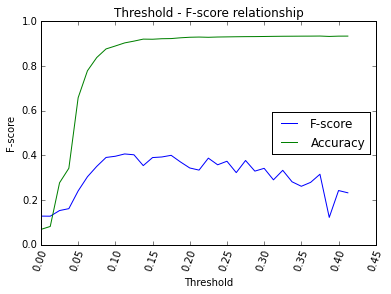

In [35]:
# plot learning curve
plt.plot(np.linspace(0, 0.4125, len(fscoreList)), fscoreList, label = 'F-score')
plt.plot(np.linspace(0, 0.4125, len(fscoreList)), accuracyList, label = 'Accuracy')

plt.legend(loc='best')
plt.xticks(rotation=70) 
plt.xlabel("Threshold")
plt.ylabel("F-score")
plt.title("Threshold - F-score relationship")

# II.5. Modified Model
    Train again with modified parameters
    (Higher f-score expected, in sacrifice of accuracy)

In [21]:
## 1. Lambda & Threshold modified
theta_modified = logisticRegression(costFunction, gradFunction, Xtrain, ytrain, bestL_F)
prediction_modified = predict(theta_modified, Xtest, ytest, bestT)

Optimization terminated successfully.
         Current function value: 0.224452
         Iterations: 86
         Function evaluations: 231
         Gradient evaluations: 231
accuracy 0.906233333333
precision 0.310474401127
recall 0.329511465603
fscore 0.319709794438


In [21]:
## 2. Polynomial term (2), C & Threshold modified

In [ ]:
# 1. Polynomial term
poly = PolynomialFeatures(2)

XtrainPoly = polyFeature(poly, Xtrain)
XcvPoly = polyFeature(poly, Xcv)

In [39]:
new = load('cs-test.csv')
Xnew, ynew = splitData(new)
Xnew = featureScale(Xnew)
Xnew = addBias(Xnew)

predictionNew = getPrediction(theta_modified, Xnew, threshold = bestT)



Data Columns:
	0 	SeriousDlqin2yrs
	1 	RevolvingUtilizationOfUnsecuredLines
	2 	age
	3 	NumberOfTime30-59DaysPastDueNotWorse
	4 	DebtRatio
	5 	MonthlyIncome
	6 	NumberOfOpenCreditLinesAndLoans
	7 	NumberOfTimes90DaysLate
	8 	NumberRealEstateLoansOrLines
	9 	NumberOfTime60-89DaysPastDueNotWorse
	10 	NumberOfDependents

Shape is:
(101503, 11)
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1               NaN                              0.885519   43   
2               NaN                              0.463295   57   
3               NaN                              0.043275   59   
4               NaN                              0.280308   38   
5               NaN                              1.000000   27   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     0   0.177513           5700   
2                                     0   0.527237           9141   
3                                     0   0.687648  

NameError: name 'theta_modified' is not defined

In [25]:
print predictionNew


1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        1
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
         ..
101474    0
101475    0
101476    0
101477    0
101478    0
101479    0
101480    0
101481    0
101482    0
101483    1
101484    0
101485    0
101486    0
101487    0
101488    0
101489    0
101490    0
101491    1
101492    0
101493    0
101494    0
101495    0
101496    0
101497    0
101498    0
101499    0
101500    1
101501    0
101502    0
101503    0
dtype: int64


In [47]:
probabilityNew = sigmoid(Xnew.dot(theta_modified))


NameError: name 'Xnew' is not defined

In [27]:
print probabilityNew


1         0.057580
2         0.056076
3         0.045385
4         0.116763
5         0.100015
6         0.036130
7         0.062592
8         0.037723
9         0.029073
10        0.689355
11        0.077122
12        0.051287
13        0.026652
14        0.089537
15        0.043834
16        0.084709
17        0.030476
18        0.068848
19        0.042103
20        0.063177
21        0.055864
22        0.033072
23        0.031187
24        0.051874
25        0.085620
26        0.045817
27        0.061183
28        0.029286
29        0.090420
30        0.054074
            ...   
101474    0.023454
101475    0.023429
101476    0.091336
101477    0.033269
101478    0.027867
101479    0.073257
101480    0.041050
101481    0.050658
101482    0.055437
101483    0.684033
101484    0.018394
101485    0.045604
101486    0.019412
101487    0.049571
101488    0.032987
101489    0.028870
101490    0.082112
101491    0.204789
101492    0.083161
101493    0.083222
101494    0.048640
101495    0.

In [28]:
probabilityNew.to_csv('probNew.csv')


In [40]:
poly = PolynomialFeatures(2)
XnewPoly = polyFeature(poly, Xnew)

clfPoly = LogisticRegression(C = 2)
clfPoly.fit(XtrainPoly, ytrain)

probaPoly = clfPoly.predict_proba(XnewPoly)

probaPolyArray = {'probability':probaPoly[:,1]}
probaPolyDF = pd.DataFrame(probaPolyArray, index = np.linspace(1,101503,101503))
probaPolyDF.to_csv('probaPoly_opt.csv',)